# Прогнозирование оттока клиентов и оптимизация выручки для сети отелей «UrbanStay»

## Цель проекта

Разработать ML-решение для прогнозирования вероятности отказа от бронирования, которое позволит бизнесу перейти от стратегии неконтролируемого овербукинга к управлению рисками на основе данных.

**Ключевые бизнес-задачи:**
* **Минимизация потерь:** Снижение доли поздних отмен с текущих 30% до 10% за счет превентивных мер.
* **Удержание загрузки:** Сохранение загрузки номерного фонда на уровне не ниже 80% (допустимое снижение не более 8%).
* **Максимизация прибыли:** Обеспечение положительного прироста выручки (Incremental Revenue), не менее 50%, за счет своевременной перепродажи номеров, по которым прогнозируется отмена.

## Формулировка задачи и выбор метрик

**Тип задачи:** Бинарная классификация.
**Целевой признак:** Факт отмены бронирования (`is_canceled`).

### Выбор метрики качества
В данной задаче стандартные метрики машинного обучения (Accuracy, Precision, Recall) являются вспомогательными, так как они не учитывают различную стоимость ошибок для бизнеса. Основным критерием эффективности выбрана бизнес-метрика **Incremental Revenue (IR)**.

### Матрица потерь и доходов
Экономическая модель строится на следующих показателях:

1.  **True Positive (TP) — Успешный перехват отмены:**
    * Модель верно предсказала отмену. Номер перепродан другому клиенту.
    * *Доход (Per_Rebooking):* +45 000 руб.

2.  **True Negative (TN) — Штатное заселение:**
    * Модель верно предсказала приезд гостя. Клиент заселился и оплатил проживание.
    * *Доход (Avg_Rev):* +64 500 руб.

3.  **False Positive (FP) — Ложная тревога (Ошибка I рода):**
    * Модель предсказала отмену, но гость приехал. Отелю приходится выплачивать компенсацию и нести репутационные издержки.
    * *Убыток (Cost_FP):* -7 000 руб.

4.  **False Negative (FN) — Пропущенная отмена (Ошибка II рода):**
    * Модель не предсказала отмену, гость не приехал. Номер простаивает.
    * *Упущенная выгода (Lost_Rev):* -64 500 руб.

### Критерии успеха модели
Модель считается успешной, если на тестовой выборке достигается **Относительный IR ≥ 50%**.

## Методология

Для решения задачи прогнозирования отмен и максимизации прибыли будет применен следующий подход:

### 1. Подготовка данных и конструирование признаков
* **Слияние данных:** Объединение таблиц бронирований и отзывов методом `merge_asof` для исключения утечки данных — использование только тех отзывов, которые были доступны на момент бронирования.
* **Текстовый анализ:** Векторизация текстов отзывов с использованием `TF-IDF` для извлечения смысловых признаков из комментариев гостей.
* **Генерация признаков:** Создание временных признаков (сезонность, день недели, месяц), расчет `lead_time` (время между бронированием и заездом) и истории клиента (предыдущие отмены).

### 2. Выбор моделей машинного обучения
Будут протестированы и сравнены следующие алгоритмы:
* **Логистическая регрессия (Logistic Regression):** В качестве базовой модели для оценки линейных зависимостей и первичной проверки гипотез.
* **Random Forest:** Как устойчивый к переобучению ансамблевый метод, позволяющий оценить нелинейные связи.
* **Градиентный бустинг (CatBoost / LightGBM / XGBoost):** Для построения более сложных зависимостей и автоматической обработки категориальных признаков.

### 3. Стратегия обучения и валидации
* **Разбиение выборки:** Данные будут разделены на три части:
    * *Train (60%):* Обучение моделей.
    * *Calibration (20%):* Калибровка вероятностей и подбор бизнес-порога.
    * *Test (20%):* Финальная оценка качества.
* **Оптимизация гиперпараметров:** Использование фреймворка **Optuna** с кросс-валидацией (3 фолда).

### 4. Калибровка и бизнес-оптимизация
Ключевая особенность решения — адаптация выходов модели под финансовые метрики:
1.  **Калибровка вероятностей:** Приведение предсказанных моделью probability к реальной частоте наступления события (отмены).
2.  **Подбор порога (Threshold Tuning):** Поиск оптимального порога классификации, максимизирующего метрику *Incremental Revenue*. Стандартный порог 0.5 не подходит из-за дисбаланса стоимости ошибок (FP стоит 7 000 руб., а FN — 64 500 руб.).

### 5. Интерпретация
Анализ важности признаков (Feature Importance) с помощью **SHAP-values** для понимания факторов, влияющих на решение клиента об отмене.

## Описание данных

В проекте используются два набора данных: история бронирований и отзывы клиентов.

### История бронирований (`hotel_bookings`)
Основная таблица, содержащая 35 341 запись.

| Признак | Описание | Тип данных (текущий) |
|---|---|---|
| `booking_id` | Уникальный идентификатор брони (ключ). | object |
| `booking_date` | Дата оформления бронирования. | object |
| `sales_channel` | Канал продаж (офлайн, онлайн, корпоративный). | object |
| `adult_count` | Количество взрослых гостей. | int64 |
| `child_count` | Количество детей. | int64 |
| `returning_customer` | Флаг повторного клиента (1 — уже был, 0 — новый). | bool |
| `previous_cancellations` | Количество отмен бронирований у клиента в прошлом. | int64 |
| `previous_no_shows` | Количество подтвержденных заездов в прошлом (история успешных заселений). | int64 |
| `booking_value` | Итоговая стоимость бронирования. | float64 |
| `days_until_checkin` | Количество дней между датой бронирования и датой заезда (`lead_time`). | int64 |
| `weekday_nights` | Количество ночей в будние дни (пн-пт). | int64 |
| `weekend_nights` | Количество ночей в выходные дни (сб-вс). | int64 |
| `meal_plan` | Тип питания. | object |
| `parking_included` | Флаг заказа парковочного места. | bool |
| `room_type` | Категория забронированного номера. | object |
| `customer_special_requests` | Количество специальных пожеланий (комментариев) от клиента. | int64 |
| **`booking_status`** | **Целевой признак.** Статус брони (`отказ_брони` или `нет_отказа`). | object |

### Отзывы клиентов (`hotel_reviews`)
Дополнительная таблица с 25 177 записями. Используется для извлечения признаков из текста и оценок.

| Признак | Описание | Тип данных (текущий) |
|---|---|---|
| `customer_id` | Уникальный идентификатор гостя. | object |
| `booking_id` | Идентификатор брони (ключ для связи с главной таблицей). | object |
| `review_date` | Дата публикации отзыва. | object |
| `stay_rating` | Оценка проживания (от 1 до 5). | int64 |
| `review_text` | Текстовый комментарий клиента. | object |


## Загрузка необходимых библиотек

- Загрузите всё, что планируете использовать для выполнения проекта.

In [343]:
!pip install -U -q pandas matplotlib seaborn phik optuna xgboost catboost lightgbm shap sqlalchemy psycopg2-binary python-dotenv

In [344]:
!pip install "scikit-learn==1.6.1"

In [345]:
!pip install "numpy<2.3"

In [346]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: 
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIB

In [347]:
import time
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import seaborn as sns
import shap
import os
from dotenv import load_dotenv
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    root_mean_squared_error,
)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
import optuna.visualization.matplotlib as vis_mpl 
from sqlalchemy import create_engine

In [348]:
!pip freeze > requirements.txt

In [349]:
#Фиксируем константы
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 3
N_JOBS = -1

In [350]:
# Показывать числа с 3 знаками после запятой в датафреймах pandas
pd.set_option('display.float_format', '{:.3f}'.format)

# Показывать все колонки (не скрывать их троеточием)
pd.set_option('display.max_columns', None)

# показывать все строки (не скрывать их троеточием)
pd.set_option('display.max_rows', None)

# не обрезать длинные строки, а показывать полностью
pd.set_option('display.max_colwidth', None)

# Устанавливает тему
sns.set_theme(style='whitegrid', palette='muted')

## Этап 1: подготовка данных

### Загрузка данных

- Все данные о работе сети отелей хранятся в базе данных на сервере. Для работы с ними в Python используйте библиотеку SQLAlchemy, чтобы выгрузить данные SQL-запросом.

- Сделайте выводы о проделанной работе.

Параметры для подключения к данным PostgreSQL:

- **Хост:** rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net

- **База данных:** data-scientist-hotels

- **Порт:** 6432

- **Пользователь:** praktikum_student

- **Пароль:** Sdf4$2;d-d30pp

Названия нужных вам таблиц — `hotel_bookings` (таблица бронирований) и `hotel_reviews` (таблица отзывов).

In [351]:
# Нужно для корректной загрузки переменных окружения из .env файла
load_dotenv()

# Параметры подключения (берутся из .env файла)
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv('DB_PASS')
DB_NAME = os.getenv('DB_NAME')

# Создание строки подключения 
connection_str = f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Подключение к базе данных и загрузка данных в DataFrame
try:
    engine = create_engine(connection_str)

    query_bookings = "SELECT * FROM hotel_bookings"
    query_reviews = "SELECT * FROM hotel_reviews"
    
    df_bookings = pd.read_sql(query_bookings, engine)
    df_reviews = pd.read_sql(query_reviews, engine)
    
    print("Данные успешно загружены из базы!")
    
except Exception as e:
    print(f"Ошибка: {e}")

Данные успешно загружены из базы!


In [352]:
# Просмотр первых строк, проверка что данные загружены корректно
display(df_bookings.head())
display(df_reviews.head())

,booking_id,booking_date,sales_channel,adult_count,child_count,returning_customer,previous_cancellations,previous_no_shows,booking_status,booking_value,days_until_checkin,weekday_nights,weekend_nights,meal_plan,parking_included,room_type,customer_special_requests
0,INN00000,2020-07-08,корпоративное_бронирование,300,0,False,0,0,нет_отказа,6700.000,21,1,0,тип_питания_2,False,тип_1,0
1,INN00001,2021-09-19,корпоративное_бронирование,3,0,True,0,1,нет_отказа,62300.000,15,5,2,тип_питания_2,False,тип_1,1
2,INN00002,2022-11-19,корпоративное_бронирование,3,0,True,0,2,нет_отказа,46900.000,96,5,2,тип_питания_1,False,тип_1,0
3,INN00003,2017-02-11,онлайн_бронирование,2,0,False,0,0,нет_отказа,53600.000,150,6,2,тип_питания_1,False,тип_1,0
4,INN00004,2019-03-06,корпоративное_бронирование,1,0,True,1,1,нет_отказа,46900.000,96,5,2,тип_питания_1,False,тип_1,1


,customer_id,booking_id,review_date,stay_rating,review_text
0,C0001,INN00000,2020-08-21,3,"Неплохо. тихо и спокойно, но отсутствие фена в номере. Кондиционер не справлялся, тяжело в номере"
1,C0001,INN00001,2021-10-15,3,"Неплохо. красивое оформление территории, но неработающий лифт."
2,C0001,INN00002,2023-03-08,4,Отличный отель! удобные парковочные места. здесь всегда ждут как родных
3,C0002,INN00003,2017-08-13,3,"Неплохо. тёплый приём, но неисправная сантехника. В номерах холодно. второго одеяла пришлось выпрашивать"
4,C0003,INN00004,2019-07-12,4,Отличный отель! качественная косметика в ванной. сервис здесь — это забота на максимум


### Исследовательский анализ данных и предобработка

- Проведите EDA, используя один из следующих инструментов на ваш выбор:

    - библиотеку pandas;
    - SQL-запросы.
    
- EDA должен включать:
    - аналитическое исследование;
    - графическое исследование для количественных данных и для категориальных данных.

- Сделайте выводы о выбросах, пропусках, дубликатах и других аномалиях  в каждой таблице.
- Проведите необходимую предобработку данных.

In [353]:
df_bookings.info()

<class 'pandas.DataFrame'>
RangeIndex: 35341 entries, 0 to 35340
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   booking_id                 35341 non-null  str    
 1   booking_date               35341 non-null  object 
 2   sales_channel              35341 non-null  str    
 3   adult_count                35341 non-null  int64  
 4   child_count                35341 non-null  int64  
 5   returning_customer         35341 non-null  bool   
 6   previous_cancellations     35341 non-null  int64  
 7   previous_no_shows          35341 non-null  int64  
 8   booking_status             35341 non-null  str    
 9   booking_value              35341 non-null  float64
 10  days_until_checkin         35341 non-null  int64  
 11  weekday_nights             35341 non-null  int64  
 12  weekend_nights             35341 non-null  int64  
 13  meal_plan                  35341 non-null  str    
 14  p

In [354]:
df_reviews.info()

<class 'pandas.DataFrame'>
RangeIndex: 25177 entries, 0 to 25176
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  25177 non-null  str   
 1   booking_id   25177 non-null  str   
 2   review_date  25177 non-null  object
 3   stay_rating  25177 non-null  int64 
 4   review_text  25177 non-null  str   
dtypes: int64(1), object(1), str(3)
memory usage: 983.6+ KB


In [355]:
# Минимальная и максимальная даты бронирования
print("Минимальная дата бронирования:", df_bookings['booking_date'].min())
print("Максимальная дата бронирования:", df_bookings['booking_date'].max())

Минимальная дата бронирования: 2017-01-01
Максимальная дата бронирования: 2025-10-22


In [356]:
# Посмотрим на количество уникальных значений в каждом столбце
for column in df_bookings.columns:
    unique_values = df_bookings[column].nunique()
    print(f"Столбец '{column}' имеет {unique_values} уникальных значений.") 

Столбец 'booking_id' имеет 30733 уникальных значений.
Столбец 'booking_date' имеет 2445 уникальных значений.
Столбец 'sales_channel' имеет 3 уникальных значений.
Столбец 'adult_count' имеет 6 уникальных значений.
Столбец 'child_count' имеет 3 уникальных значений.
Столбец 'returning_customer' имеет 2 уникальных значений.
Столбец 'previous_cancellations' имеет 6 уникальных значений.
Столбец 'previous_no_shows' имеет 6 уникальных значений.
Столбец 'booking_status' имеет 2 уникальных значений.
Столбец 'booking_value' имеет 1766 уникальных значений.
Столбец 'days_until_checkin' имеет 79 уникальных значений.
Столбец 'weekday_nights' имеет 14 уникальных значений.
Столбец 'weekend_nights' имеет 4 уникальных значений.
Столбец 'meal_plan' имеет 5 уникальных значений.
Столбец 'parking_included' имеет 2 уникальных значений.
Столбец 'room_type' имеет 7 уникальных значений.
Столбец 'customer_special_requests' имеет 6 уникальных значений.


In [357]:
# Исключаем колонки с большим количеством уникальных значений
cols_exlude = ['booking_id', 'booking_date', 'booking_value', 'days_until_checkin']

# Формируем список колонок для анализа).
cols_to_analyze = [col for col in df_bookings.columns if col not in cols_exlude]

summary = []

# Проходимся только по отобранным колонкам
for col in cols_to_analyze:
    unique_vals = df_bookings[col].unique()
    
    vals_to_show = sorted(unique_vals)
    
    summary.append({
        'Признак': col,
        'Всего уникальных': len(unique_vals),
        'Примеры значений': vals_to_show
    })

# Выводим результат
pd.DataFrame(summary).sort_values(by=['Всего уникальных'], ascending=[False])

,Признак,Всего уникальных,Примеры значений
7,weekday_nights,14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]"
11,room_type,7,"[тип_1, тип_2, тип_3, тип_4, тип_5, тип_6, тип_7]"
12,customer_special_requests,6,"[0, 1, 2, 3, 4, 5]"
4,previous_cancellations,6,"[0, 1, 2, 3, 4, 5]"
1,adult_count,6,"[1, 2, 3, 100, 200, 300]"
5,previous_no_shows,6,"[0, 1, 2, 3, 4, 5]"
9,meal_plan,5,"[не выбран, не выбрант, тип_питания_1, тип_питания_2, тип_питания_3]"
8,weekend_nights,4,"[0, 2, 4, 6]"
0,sales_channel,3,"[корпоративное_бронирование, онлайн_бронирование, офлайн_бронирование]"
2,child_count,3,"[0, 1, 2]"


In [358]:
# Сразу чистим adult_count от неверных записей, создаём маску для строк, где adult_count больше 99, и делим эти значения на 100
mask = df_bookings['adult_count'] > 99
df_bookings.loc[mask, 'adult_count'] = df_bookings.loc[mask, 'adult_count'] / 100

In [359]:
# Тип питания "не выбранто" заменим на "не выбран"
df_bookings['meal_plan'] = df_bookings['meal_plan'].replace('не выбрант', 'не выбран')

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />

    Adult_count значения 100, 200, 300 являются явной ошибкой записи. Для облегчения дальнейшего анализа, исправим эти значения уже сейчас.
    Тоже самое сделаем с типом питания, где есть явные опечатки.
</div>

In [360]:
# Уникальные значения в колонке 'stay_rating' в df_reviews
df_reviews['stay_rating'].unique()

array([3, 4, 2, 5])

In [361]:
# Максимальный и минимальный размер отзыва (количество символов в тексте отзыва)
df_reviews['review_length'] = df_reviews['review_text'].apply(len)
print("Минимальный размер отзыва:", df_reviews['review_length'].min())
print("Максимальный размер отзыва:", df_reviews['review_length'].max())

Минимальный размер отзыва: 26
Максимальный размер отзыва: 225


In [362]:
# Посмотрим на полные дубликаты в df_bookings и df_reviews
full_duplicates = df_bookings.duplicated().sum()
print(f"Количество полных дубликатов в df_bookings: {full_duplicates}")
full_duplicates_reviews = df_reviews.duplicated().sum()
print(f"Количество полных дубликатов в df_reviews: {full_duplicates_reviews}")

Количество полных дубликатов в df_bookings: 4608
Количество полных дубликатов в df_reviews: 0


In [363]:
# Полные дубликаты в df_bookings
duplicate_rows = df_bookings[df_bookings.duplicated(keep=False)]

# Визуально убедимся, что это действительно дубликаты
display(duplicate_rows.sort_values(by=duplicate_rows.columns.tolist()).head(10))


,booking_id,booking_date,sales_channel,adult_count,child_count,returning_customer,previous_cancellations,previous_no_shows,booking_status,booking_value,days_until_checkin,weekday_nights,weekend_nights,meal_plan,parking_included,room_type,customer_special_requests
7,INN00007,2017-08-21,корпоративное_бронирование,2,0,True,1,1,нет_отказа,67000.000,144,8,2,тип_питания_1,False,тип_4,0
33901,INN00007,2017-08-21,корпоративное_бронирование,2,0,True,1,1,нет_отказа,67000.000,144,8,2,тип_питания_1,False,тип_4,0
13,INN00013,2021-10-22,онлайн_бронирование,3,2,True,0,1,отказ_брони,53600.000,76,6,2,тип_питания_1,False,тип_6,1
31377,INN00013,2021-10-22,онлайн_бронирование,3,2,True,0,1,отказ_брони,53600.000,76,6,2,тип_питания_1,False,тип_6,1
22,INN00022,2020-03-02,корпоративное_бронирование,3,0,True,0,3,отказ_брони,33500.000,77,5,0,тип_питания_1,False,тип_4,1
33239,INN00022,2020-03-02,корпоративное_бронирование,3,0,True,0,3,отказ_брони,33500.000,77,5,0,тип_питания_1,False,тип_4,1
27,INN00027,2020-08-21,корпоративное_бронирование,2,1,False,0,0,нет_отказа,80400.000,150,10,2,не выбран,False,тип_4,0
33221,INN00027,2020-08-21,корпоративное_бронирование,2,1,False,0,0,нет_отказа,80400.000,150,10,2,не выбран,False,тип_4,0
48,INN00048,2018-05-20,офлайн_бронирование,2,0,False,0,0,нет_отказа,67000.000,11,8,2,не выбран,False,тип_4,2
32499,INN00048,2018-05-20,офлайн_бронирование,2,0,False,0,0,нет_отказа,67000.000,11,8,2,не выбран,False,тип_4,2


In [364]:
# Удалим полные дубликаты из df_bookings
df_bookings = df_bookings.drop_duplicates().reset_index(drop=True)

In [365]:
# Посмотрим, есть ли строки с одинаковым booking_id в df_bookings
duplicate_booking_ids = df_bookings[df_bookings.duplicated(subset=['booking_id'], keep=False)]
print(f"Количество строк с одинаковым booking_id: {duplicate_booking_ids.shape[0]}")

Количество строк с одинаковым booking_id: 0


In [366]:
# Посмотрим, есть ли строки где все поля, кроме booking_id, совпадают
cols_to_check = [col for col in df_bookings.columns if col != 'booking_id']

# Ищем дубликаты по этому списку
dups_no_id = df_bookings[df_bookings.duplicated(subset=cols_to_check, keep=False)]

print(f"Количество строк-дубликатов (без учета ID): {dups_no_id.shape[0]}")

Количество строк-дубликатов (без учета ID): 0


In [367]:
def check_missing_empty_spaces(df):
    # Проверим датасет на пропуски, пустые строки и строки состоящие только из пробелов
    missing_info = {}

    for col in df.columns:
        # Считаем пропуски
        count = df[col].isnull().sum()

        # Проверяем только для строковых столбцов
        if df[col].dtype == 'object':
            #Приведем к строковому типу 
            str_col = df[col].astype(str)

            #Ищем пустые строки ''
            count += (str_col == '').sum()

            #Ищем пробелы, str.isspace() возвращает True для строк, состоящих только из пробелов
            count += str_col.str.isspace().sum()

            #ищем np.nan, которые были преобразованы в строки 'nan' при приведении типа
            count += (str_col.str.lower() == 'nan').sum()
            count += (str_col.str.lower() == 'none').sum()

        # Добавляем в словарь только если есть пропуски
        if count > 0:
            missing_info[col] = count

    if missing_info == {}:
        print('Пропусков, пустых строк и пробелов не найдено!')
    else:
        # Создаем датафрейм из словаря
        result_df = pd.DataFrame.from_dict(missing_info, orient='index', columns=['missing_count'])
        result_df = result_df.sort_values('missing_count', ascending=False)

        # Добавляем колонку доли от общего числа строк
        result_df['missing_share'] = (result_df['missing_count'] / len(df) * 100).round(2)
        display(result_df)

In [368]:
check_missing_empty_spaces(df_bookings)
check_missing_empty_spaces(df_reviews)

Пропусков, пустых строк и пробелов не найдено!
Пропусков, пустых строк и пробелов не найдено!


In [369]:
# Есть ли строки с weekday_nights = 0 и weekend_nights = 0
no_nights = df_bookings[(df_bookings['weekday_nights'] == 0) & (df_bookings['weekend_nights'] == 0)]
print(f"Количество строк с weekday_nights = 0 и weekend_nights = 0: {no_nights.shape[0]}")

# Есть ли строки где 0 гостей, adults_count = 0 и child_count = 0
no_guests = df_bookings[(df_bookings['adult_count'] == 0) & (df_bookings['child_count'] == 0)]
print(f"Количество строк с adult_count = 0 и child_count = 0: {no_guests.shape[0]}")

Количество строк с weekday_nights = 0 и weekend_nights = 0: 0
Количество строк с adult_count = 0 и child_count = 0: 0


In [370]:
def plot_numerical_distributions(df, plot_type='hist', columns=None, n_cols=4):
    """
    Строит графики (hist, box или count) с адаптивным размером в зависимости от n_cols.
    """
    # Если колонки не указаны, выбираем все числовые
    if columns is None:
        if plot_type == 'count':
            cols_to_plot = df.select_dtypes(include=['str', 'category']).columns.tolist()
        else:
            cols_to_plot = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        cols_to_plot = columns

    if not cols_to_plot:
        print("Нет колонок для построения")
        return

    # Считаем количество рядов, двойной минус для округления вверх
    n_rows = -(-len(cols_to_plot) // n_cols)
    
    # Размеры графиков адаптивные
    if n_cols == 1:
        width_per_col = 10 
        height_per_row = 5
    elif n_cols == 2:
        width_per_col = 7
        height_per_row = 5
    else:
        width_per_col = 4
        height_per_row = 4
        
    # Итоговый размер фигуры = (ширина_одного * кол-во_столбцов, высота_одного * кол-во_строк)
    plt.figure(figsize=(width_per_col * n_cols, height_per_row * n_rows))
    
    # Строим графики
    for i, col in enumerate(cols_to_plot, start=1):
        ax = plt.subplot(n_rows, n_cols, i)
        
        if plot_type == 'box':
            sns.boxplot(y=df[col], ax=ax)
            ax.set_title(col)

        elif plot_type == 'count':
            sns.countplot(data=df, x=col, ax=ax, palette='muted', order=df[col].value_counts().index)
            ax.set_title(col)
            ax.tick_params(axis='x', rotation=30)

        else:
            sns.histplot(data=df, x=col, kde=True, ax=ax)
            ax.set_title(col)
            ax.set_xlabel(col)

    plt.tight_layout()
    plt.show()

In [371]:
# Приведем booking_date и review_date к типу datetime
df_bookings['booking_date'] = pd.to_datetime(df_bookings['booking_date'], errors='coerce')
df_reviews['review_date'] = pd.to_datetime(df_reviews['review_date'], errors='coerce')

In [372]:
# Вытащим год и месяц из даты бронирования в отдельный признак
df_bookings['booking_year'] = df_bookings['booking_date'].dt.year.astype(int)
df_bookings['booking_month'] = df_bookings['booking_date'].dt.month.astype(int)

/tmp/ipykernel_12474/2276982380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_bookings, x='booking_year', palette='muted', order=df_bookings['booking_year'].value_counts().index)


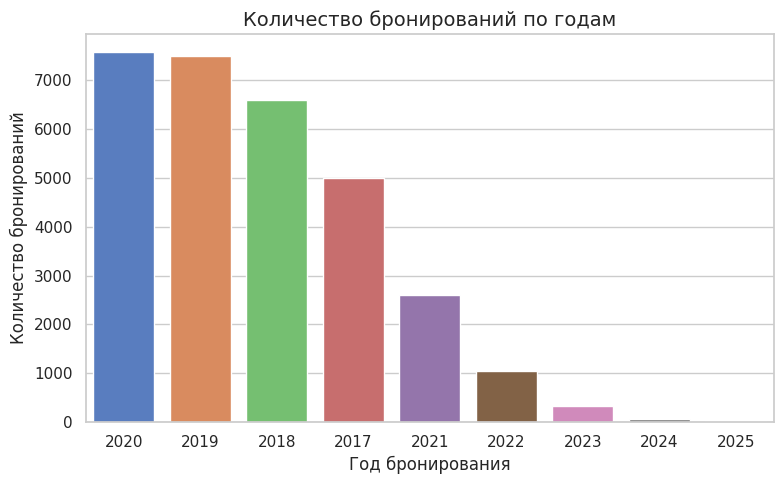

In [373]:
# Отдельно посмотрим количество записей по годам
plt.figure(figsize=(8, 5))
sns.countplot(data=df_bookings, x='booking_year', palette='muted', order=df_bookings['booking_year'].value_counts().index)
plt.title('Количество бронирований по годам', fontsize=14)
plt.xlabel('Год бронирования', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.tight_layout()
plt.show()

In [374]:
# Сколько записей за каждый год
bookings_per_year = df_bookings['booking_year'].value_counts().sort_index()
display(bookings_per_year)

booking_year
2017    4991
2018    6604
2019    7506
2020    7570
2021    2598
2022    1050
2023     329
2024      68
2025      17
Name: count, dtype: int64

In [375]:
# Обрежем хвост дат, данные за 2024 и 2025 года
df_bookings = df_bookings[df_bookings['booking_year'] < 2024]

In [376]:
numerical_cols = df_bookings.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_bookings.select_dtypes(include=['object', 'category', 'bool', 'str']).columns.tolist()

# Booking_month лучше считать как категориальный признак, так как это не непрерывная числовая переменная
numerical_cols.remove('booking_month')
categorical_cols.append('booking_month')

# Describe числовых признаков
df_bookings[numerical_cols].describe(percentiles=[.10, .25, .5, .75, .9, .95, .99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
adult_count,30648.000,1.799,0.751,1.000,1.000,1.000,2.000,2.000,3.000,3.000,3.000,3.000
child_count,30648.000,0.357,0.585,0.000,0.000,0.000,0.000,1.000,1.000,2.000,2.000,2.000
previous_cancellations,30648.000,0.358,0.630,0.000,0.000,0.000,0.000,1.000,1.000,2.000,3.000,5.000
previous_no_shows,30648.000,0.831,0.920,0.000,0.000,0.000,1.000,1.000,2.000,3.000,4.000,5.000
booking_value,30648.000,61704.495,42726.480,0.000,13400.000,33500.000,60300.000,80400.000,113900.000,140700.000,193556.603,417221.200
days_until_checkin,30648.000,100.611,71.972,2.000,8.000,45.000,90.000,144.000,209.000,222.000,300.000,300.000
weekday_nights,30648.000,6.539,3.336,1.000,2.000,5.000,6.000,9.000,11.000,13.000,15.000,15.000
weekend_nights,30648.000,1.956,1.476,0.000,0.000,0.000,2.000,2.000,4.000,4.000,6.000,6.000
customer_special_requests,30648.000,0.621,0.784,0.000,0.000,0.000,0.000,1.000,2.000,2.000,3.000,5.000
booking_year,30648.000,2019.021,1.390,2017.000,2017.000,2018.000,2019.000,2020.000,2021.000,2021.000,2023.000,2023.000


In [377]:
# Переведем booking_value в int, так как это целочисленный признак, а не вещественный
df_bookings['booking_value'] = df_bookings['booking_value'].astype(int)

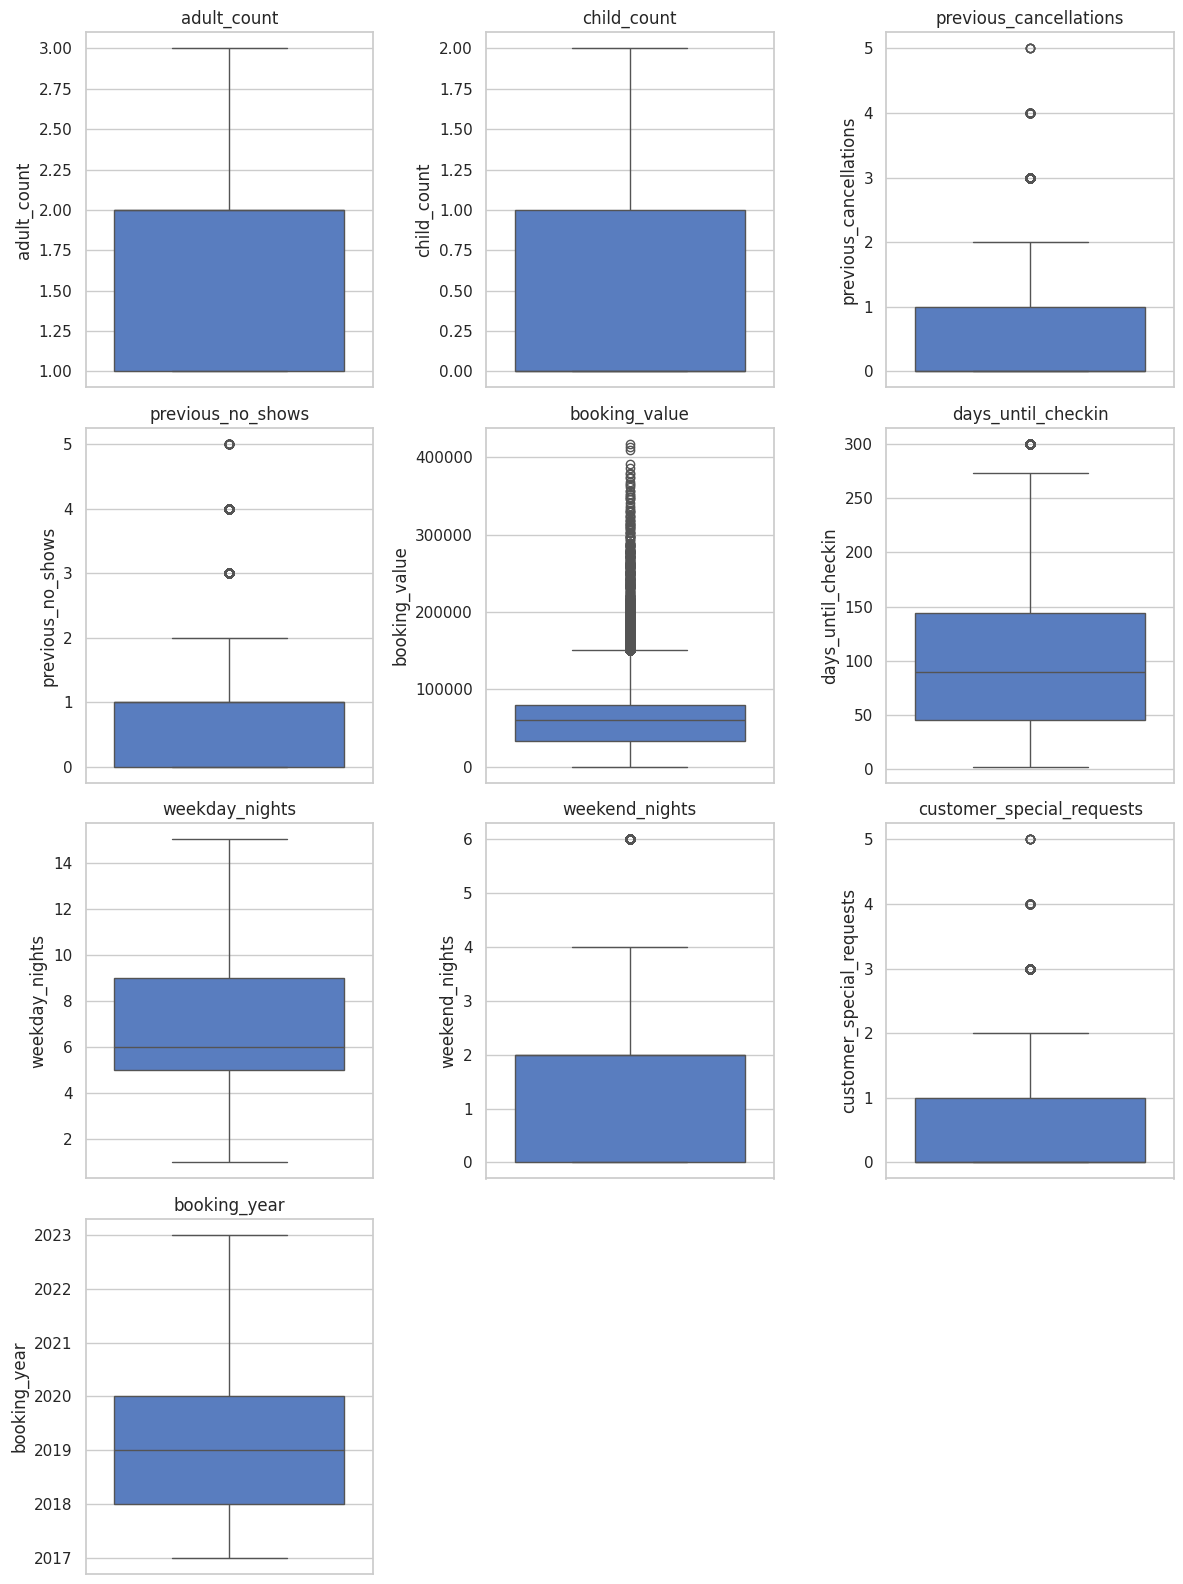

In [378]:
# Ящик с усами для числовых признаков
plot_numerical_distributions(df_bookings, plot_type='box', columns=numerical_cols, n_cols=3)

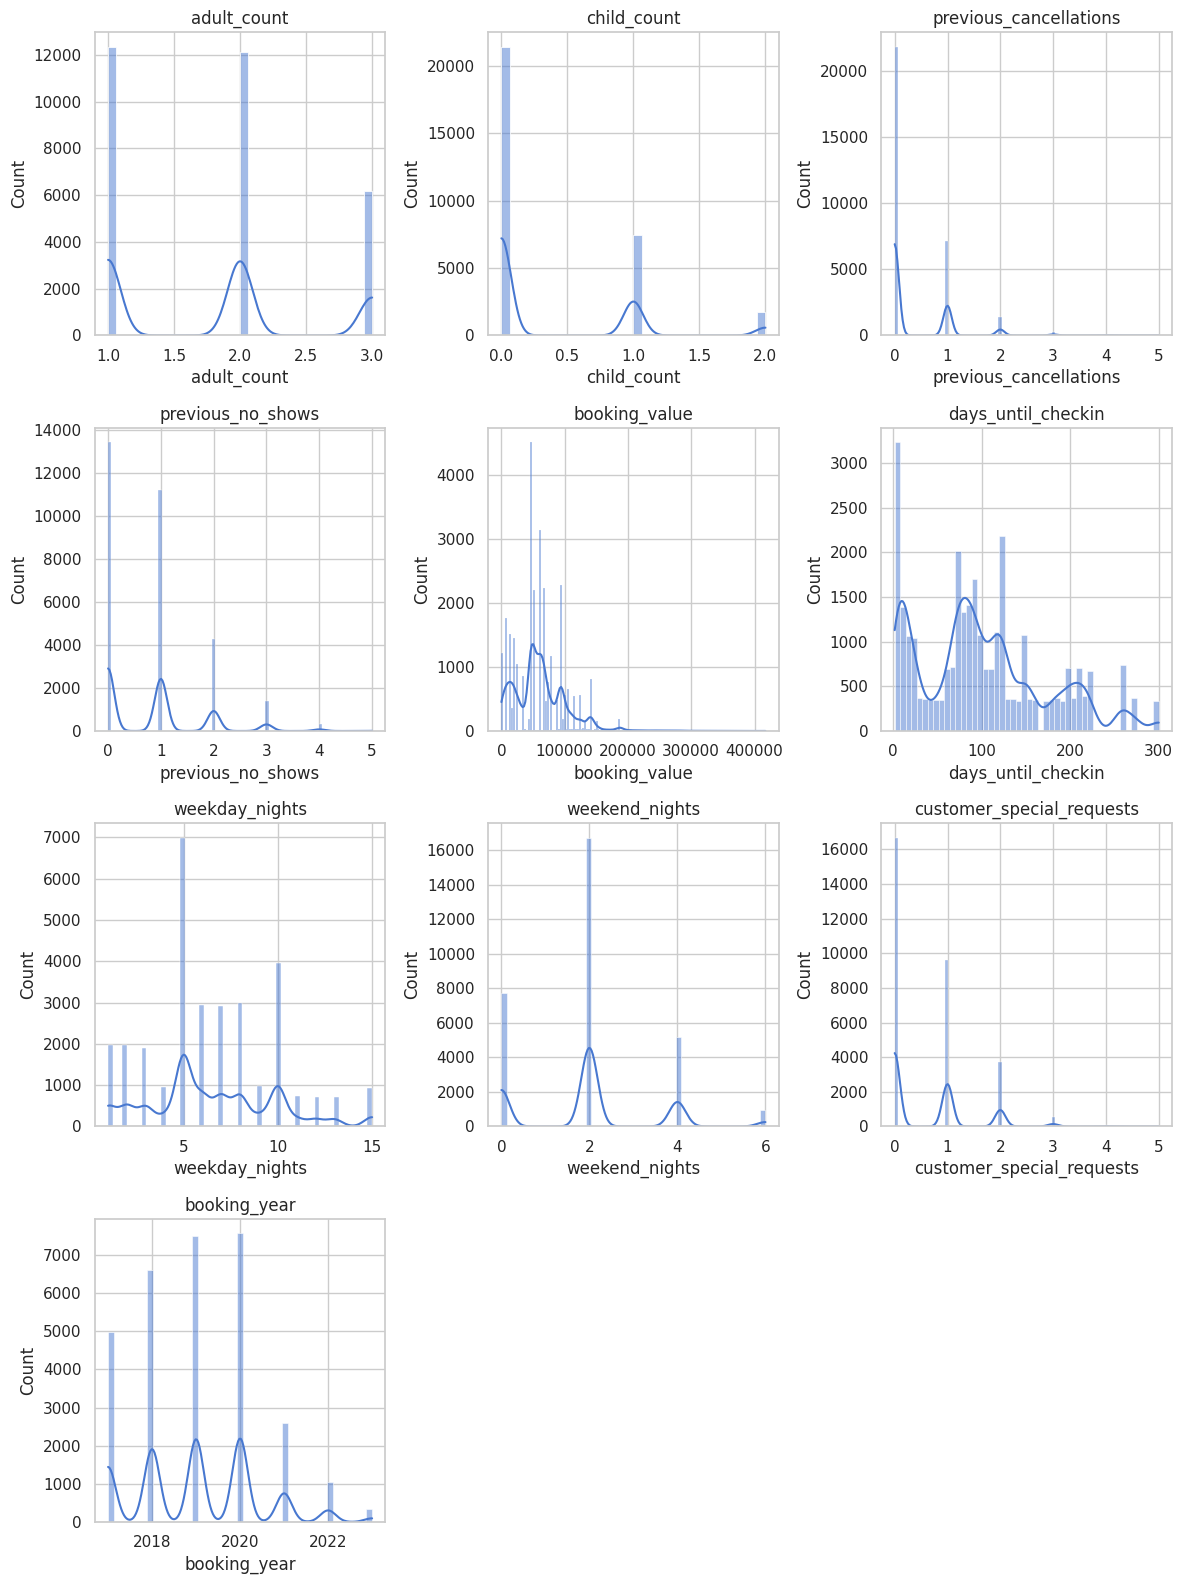

In [379]:
# Гистограммы для числовых признаков
plot_numerical_distributions(df_bookings, plot_type='hist', columns=numerical_cols, n_cols=3)

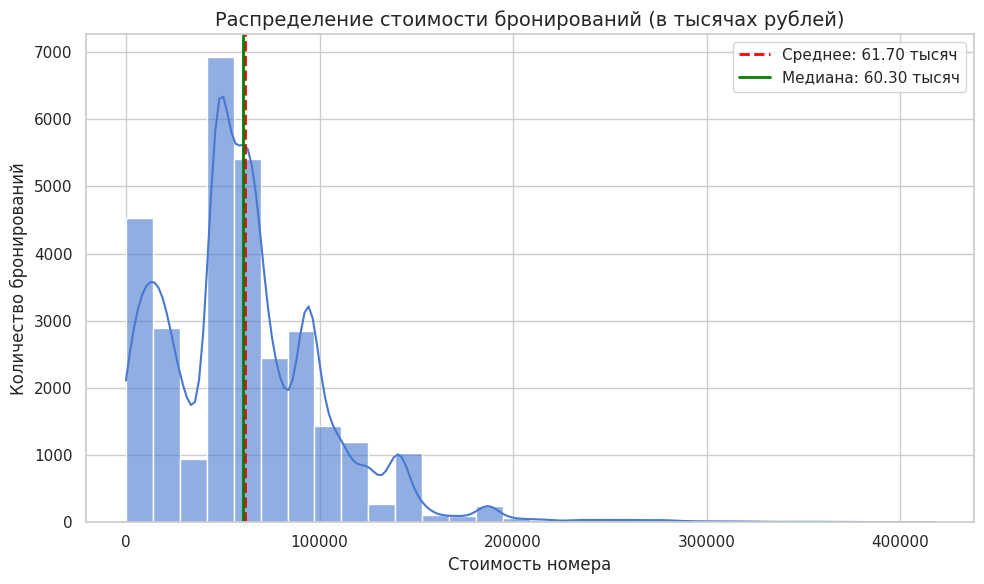

In [380]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_bookings, x='booking_value', kde=True, alpha=0.6, bins=30)

mean_val = df_bookings['booking_value'].mean()
median_val = df_bookings['booking_value'].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_val/1000:.2f} тысяч')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Медиана: {median_val/1000:.2f} тысяч')


plt.title('Распределение стоимости бронирований (в тысячах рублей)', fontsize=14)
plt.xlabel('Стоимость номера', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

In [381]:
# Уберем booking_id и booking_date из категориальных признаков
categorical_cols.remove('booking_id')

/tmp/ipykernel_12474/684863247.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, palette='muted', order=df[col].value_counts().index)
/tmp/ipykernel_12474/684863247.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, palette='muted', order=df[col].value_counts().index)
/tmp/ipykernel_12474/684863247.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, palette='muted', order=df[col].value_counts().index)
/tmp/ipykernel_12474/684863247.py:44: FutureWarning: 

Passin

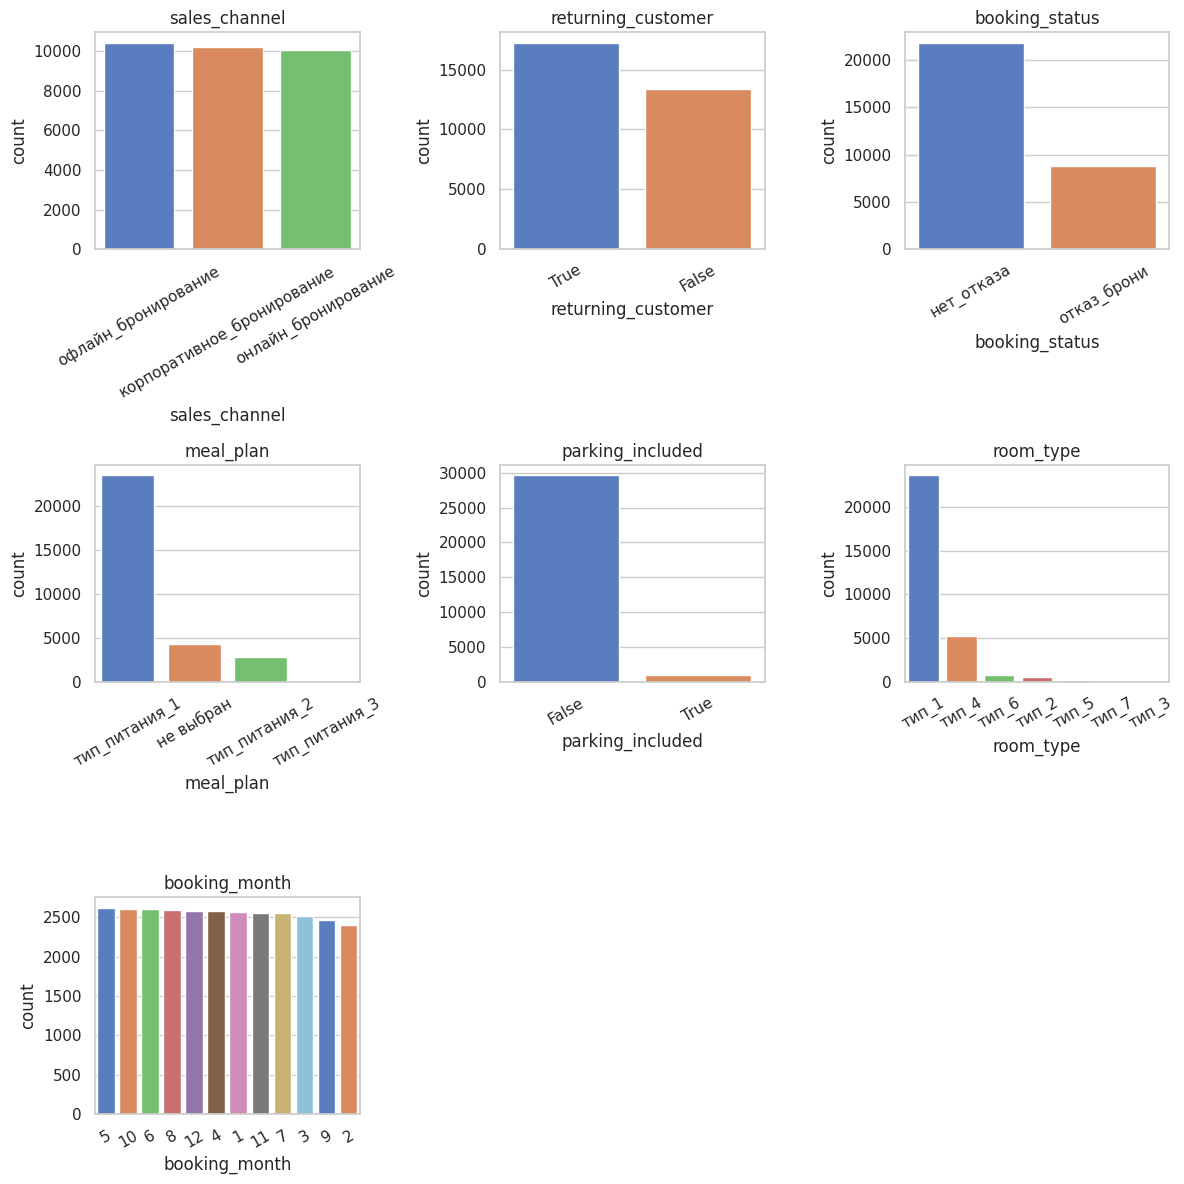

In [382]:
# Построим countplot для всех категориальных признаков
plot_numerical_distributions(df_bookings, plot_type='count', columns=categorical_cols, n_cols=3)

In [383]:
# Посмотрпим распределение целевого признака booking_status в абсолютных числах и в процентах
booking_status_counts = df_bookings['booking_status'].value_counts()
booking_status_percent = df_bookings['booking_status'].value_counts(normalize=True) * 100
display(booking_status_counts)
display(booking_status_percent)

booking_status
нет_отказа     21816
отказ_брони     8832
Name: count, dtype: int64

booking_status
нет_отказа    71.182
отказ_брони   28.818
Name: proportion, dtype: float64

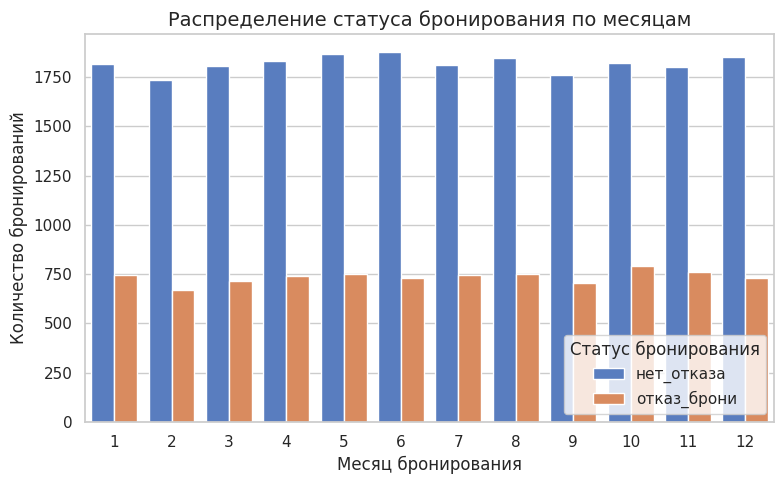

In [384]:
# Посмотрим на корреляцию между booking_status и booking_month
plt.figure(figsize=(8, 5))
sns.countplot(data=df_bookings, x='booking_month', hue='booking_status', palette='muted', order=sorted(df_bookings['booking_month'].unique()))
plt.title('Распределение статуса бронирования по месяцам', fontsize=14)
plt.xlabel('Месяц бронирования', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.legend(title='Статус бронирования', loc='lower right')
plt.tight_layout()
plt.show()

---

## Вывод по исследовательскому анализу данных (EDA)

В ходе предварительного анализа и предобработки данных была проведена проверка качества датасета `hotel_bookings` и `hotel_reviews`. Выполнены очистка от шума, обработка аномалий и оценка распределений.

### 1. Качество данных и очистка

* **Дубликаты:**
* В таблице бронирований обнаружено и удалено **4 608** полных дубликатов. Это существенный объем (около 13% от исходных данных), удаление которого необходимо для предотвращения утечки данных и смещения оценок модели.
* Скрытых дубликатов (разные ID, но идентичные параметры брони) не обнаружено.
* В таблице отзывов дубликатов нет.


* **Пропуски:** В данных отсутствуют пропущенные значения (`NaN`), пустые строки или лишние пробельные символы.
* **Логическая целостность:**
* Проведена проверка на корректность данных: отсутствуют записи с 0 гостей (`adult_count` + `child_count` = 0) или 0 ночей проживания.



### 2. Обработка аномалий и выбросов

* **Аномалии в количестве взрослых (`adult_count`):** Выявлены значения `100`, `200`, `300`. Вероятнее всего, это ошибка ввода (лишние нули). Значения, превышающие 99, были скорректированы делением на 100. Теперь признак находится в логичном диапазоне [1, 3].
* **Опечатки в категориях:** В столбце `meal_plan` исправлена опечатка в значении категории: «не выбрант»  «не выбран».
* **Временной период:**
* Исходный диапазон данных: с 2017 по 2025 год.
* Данные за **2024 и 2025 годы** (суммарно менее 100 записей) были удалены, так как они составляют незначительный «хвост» распределения и недостаточны для выявления статистических закономерностей, но могут создать шум при обучении. Основной массив данных приходится на 2017–2020 годы.



### 3. Анализ распределений

* **Целевая переменная (`booking_status`):**
* Наблюдается дисбаланс классов, но он не критический.
* `нет_отказа` (гости приехали): **21 816** (≈71%)
* `отказ_брони` (отмена): **8 832** (≈29%)
* Такое соотношение (примерно 2.5 к 1) позволяет использовать стандартные методы обучения, но требует внимания при выборе метрик (акцент на IR и Precision/Recall, а не Accuracy).


* **Стоимость (`booking_value`):** Распределение стоимости близко к нормальному, но имеет «тяжелый правый хвост» (выбросы с очень высокой стоимостью). Медиана (~60.3 тыс.) и среднее (~61.7 тыс.) находятся рядом.
* **Категориальные признаки:**
* **Тип питания:** Доминирует `тип_питания_1`.
* **Тип номера:** Подавляющее большинство бронирований приходится на `тип_1`.
* **Канал продаж:** Распределение между онлайн, офлайн и корпоративными клиентами достаточно равномерное.



### Итог этапа

Данные очищены от явных ошибок и дубликатов. Сформирован качественный датасет для дальнейшего этапа создания таблицы, конструирования признаков и построения моделей машинного обучения.

### Объединение таблиц

- Соедините таблицу отзывов с таблицей бронирований. Руководствуйтесь правилом: для каждой даты бронирования в столбце `booking_date` нужно взять комментарий и оценку клиента по предыдущей ближайшей дате отзывов, указанной в столбце `review_date`. Это позволит связать обратную связь клиента с конкретным периодом проживания, что критически важно для анализа удовлетворённости гостей.

- Сделайте выводы о том, как прошло объединение и что получилось в результате.

### Создание новых признаков

- Создайте не менее трёх признаков на основе данных о брони.

- Создайте новые признаки на основе текстов отзывов, используя один из методов векторизации. Решение о количестве таких признаков примите самостоятельно.

- Сделать выводы о созданных признаках.

In [ ]:
# Временные и количественные признаки

# Неделя года (поможет модели уловить сезонность и праздники)
df_bookings['week_number'] = df_bookings['booking_date'].dt.isocalendar().week.astype(int)

# Всего ночей (сумма будней и выходных)
df_bookings['total_nights'] = df_bookings['weekday_nights'] + df_bookings['weekend_nights']

# Всего гостей
df_bookings['total_guests'] = df_bookings['adult_count'] + df_bookings['child_count']

# Финансовые признаки

# Цена за ночь. Добавим защиту от деления на 0
df_bookings['price_per_night'] = df_bookings['booking_value'] / df_bookings['total_nights'].replace(0, 1)

# Цена на человека. Добавим защиту от деления на 0
df_bookings['price_per_person'] = df_bookings['booking_value'] / df_bookings['total_guests'].replace(0, 1)


# Поведенческие и сегментационные признаки

# Семья (есть хотя бы один ребенок), bool
df_bookings['is_family'] = (df_bookings['child_count'] > 0).astype(int)

# Одиночный путешественник (1 взрослый, 0 детей), bool
df_bookings['is_single'] = ((df_bookings['adult_count'] == 1) & (df_bookings['child_count'] == 0)).astype(int)

# Транзитный пассажир / Короткая поездка (1 ночь), bool
df_bookings['one_night_stay'] = (df_bookings['total_nights'] == 1).astype(int)


# Биннинг времени бронирования

# Создаем категории:
# - last_minute (0-3 дня): бронируют перед заездом.
# - short (4-14 дней): планируют за пару недель.
# - medium (15-60 дней): стандартное планирование отпуска.
# - long (61+ дней): раннее бронирование, высокий риск изменения планов.

bins = [-1, 3, 14, 60, 1000]
labels = ['last_minute', 'short', 'medium', 'long']

df_bookings['lead_time_category'] = pd.cut(
    df_bookings['days_until_checkin'], 
    bins=bins, 
    labels=labels
)

### Анализ итоговой таблицы

- Проанализируйте итоговую таблицу.

- Сделайте выводы о данных для моделирования.

## Этап 2: моделирование

### Обучение и оптимизация модели

- Выберите и обучите не менее двух моделей из списка:

  - Random Forest;

  - CatBoost;

  - LightGBM;

  - XGBoost;

  - любую другую на ваш выбор.

- Разделите данные на три выборки:
  - Обучающую — для обучения моделей (60% данных);
  - Калибровочную — для проведения калибровки модели (20% данных);
  - Тестовую — для финальной оценки качества выбранной модели (20% данных).

- Проведите кросс-валидацию, используйте три фолда. Размер выборки для валидации — 2000.

- Оптимизируйте гиперпараметры с помощью Optuna. Количество гиперпараметров — не менее трёх. Ключевая метрика для оптимизации — Incremental Revenue.

- Сделайте выводы о том, какая модель показала лучшие результаты.

### Калибровка модели и пересчёт результатов

- Выбрав модель, откалибруйте её на полной тренировочной выборке, чтобы повысить обобщающую способность и адаптировать предсказания под бизнес-задачи.

- Сделайте о результатах калибровки модели.

### Поиск порога классификации

- Используя откалиброванную модель и калибровочную выборку, найдите порог классификации, при котором достигается максимальный Incremental Revenue.

- Сделайте выводы о пороге классификации.

### Анализ матрицы классификаций

Оцените стабильность модели на тестовых данных.
- Постройте:
    - матрицу ошибок на калибровочных данных;
    - матрицу ошибок на тестовых данных.

- Посчитайте IR на калибровочных и на тестовых данных.

- Сделайте вывод о стабильности модели.

### Фиксирование итоговой модели

- Зафиксисруйте лучшую модель и найденный порог.


### Анализ важности признаков

- Оцените важность признаков с помощью любого подходящего инструмента:
  - feature_importances;
  - SHAP;
  - встроенной в модель собственной функции оценки важности.

- Сделайте выводы о влиянии признаков на целевую переменную.

## Этап 3: расчёт экономической эффективности модели

Оцените, насколько выгодно внедрять выбранную модель в работу отеля. Для этого нужно выяснить, какой экономический эффект даёт модель и укладываются ли ключевые метрики в заданный уровень.

Если расчёты покажут, что какой-либо показатель не достигает необходимого уровня, то это сигнал к доработке модели. Возможно, вам нужно пересмотреть порог классификации, добавить новые признаки, поменять модель, по-другому предобработать исходные данные — экспериментируйте!

- Шаг 1: подготовка данных. Подготовьте данные для расчётов. Данные для показателей до внедрения модели рассчитывайте с использованием тестовых данных `y_test`, данные после внедрения получите с помощью предсказаний модели `y_pred`.

- Шаг 2: расчёт показателей до и после внедрения модели. Вычислите:
  - Долю отмен бронирования до и после внедрения модели;
  - Загрузку отеля до и после внедрения модели;
  - IR.

- Шаг 3: расчёт динамики показателей. Вычислите:
  - Динамику доли отмен бронирования;
  - Динамику загрузки отеля;
  - Относительный IR — на сколько процентов `IR_после` выше, чем `IR_до`.


Ваша модель должна достигнуть следующих результатов:

- Доля отмен после внедрения модели — 10%

- Загрузка отеля не должна уменьшиться больше чем на 8% после внедрения модели.

- Относительный IR должен составить не менее 50%.

Сделайте выводы о том, получилось ли достичь целевых показателей для бизнеса.


## Этап 4: выводы по проекту

Выводы должны состоять из двух логически связанных разделов:

- «Проделанная работа» — описание этапов и решений;

- «Бизнес‑выводы» — интерпретация результатов и рекомендации.

В каждом разделе опишите результаты без избыточной детализации, с опорой на факты и цифры.

### Выводы о проделанной работе

В этом разделе опишите основные этапы проделанной работы по построению модели. Опишите, как проходили следующие шаги:
- Подготовка данных;
- Моделирование;
- Оценка метрик;
- Анализа важности факторов.

### Выводы по анализу эффективности модели

В этом разделе ответьте на вопрос: «Что это значит для бизнеса?» Для этого интерпретируйте результаты вашей работы, дайте им экономическую оценку, а заказчику — рекомендации.

Включите следующие пункты:

- Итоговая оценка достижения цели:
  - Вспомните цель проекта и определите, достигнута ли она. Аргументируйте свой ответ.

- Результаты по ключевым метрикам. Для каждого показателя приведите:
  - Значение до внедрения модели.
  - Значение после внедрения.
  - Изменение в процентах с расчётом по формуле.
  
- Сообщите заказчику, достигнуты ли целевые показатели по метрикам.

- Анализ важности признаков:
  - Опишите для заказчиков основные 10 признаков, влияющих на резкие отмены заказов.
  - Кратко объясните, как они влияют на целевую переменную. Пример такого объяснения: «лояльность клиента снижает риск отмены на 15%».

- Рекомендации для бизнеса:
  - Предложите 2–3 конкретных шага по оптимизации работы сети отелей.